# Satellite Image Analysis GGS416 

In this tutorial we are going to focus on how to clip a satellite image, and then export the resulting data. 

This is an essential skill, as you need to be able to read in, manipulate and export imagery. 



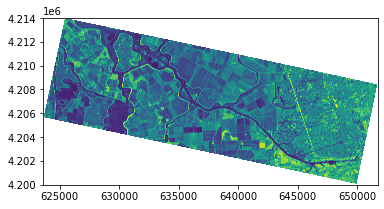

<AxesSubplot:>

In [1]:
import rasterio
from matplotlib import pyplot as plt

# This notebook explores a single 4 band (blue, green, red, NIR) PlanetScope scene in a UTM projection.
# In our image path '..' means to go up one directory from where this notebook is saved.
# Then, 'week3' means to go into the 'week3' directory and find '20160831_180302_0e26_3B_Visual.tif'.
# We downloaded this image in the Planet API extraction
image_file = "../week3/20160831_180302_0e26_3B_Visual.tif"

# Use Rasterio to open the image.
my_image = rasterio.open(image_file)
my_image

# We can take a quick look using the rasterio.plot.show function 
# This is a matplotlib shortcut for visualizing the raster 
from rasterio.plot import show
show(my_image)

Now we need to define a shape to intersect with the existing image. 

We can obtain a spatial boundary in multiple ways:
- Specify our own geojson file (as we will do here). 
- Import a existing .shp file using either `geopandas` or `fiona` (geospatial Python packages).

First, we're going to try create our own geojson file, as it's easier for this first example. 

Let's get the bounding box coordinates for our current image:


In [2]:
# Allocate our image bounds to four variables
xmin, ymin, xmax, ymax = my_image.bounds

# xmin is the minimum value on the x axis
# ymin is the minimum value on the y axis
# xmax is the maximum value on the x axis
# ymax is the maximum value on the y axis

# Let's inspect our values. 
# You can confirm these using QGIS or ArcMap (I like to do this for correctness)
xmin, ymin, xmax, ymax

(623577.0, 4199985.0, 651732.0, 4214037.0)

We can now create a geojson using these coordinates. 

Remember we have covered this geojson data structure before, earlier in this class. 

However, if we use the same coordinates as the existing bounding box, we will just produce the same image. 

Therefore, we need to change the coordinates to an area inside our existing box, to clip. 

We can do this by obtaining the range of the values on the x and y axes.

Then we can respecify the max values after subtracting half the range, making this image only 1/4 of the original image area. 

In [3]:
# So we can get our image bounds
xmin, ymin, xmax, ymax = my_image.bounds

# Let's get the x and y range first 
x_range = xmax - xmin
y_range = ymax - ymin
print(x_range, y_range)

# Then we can respecify the maximum values to be smaller
xmin = xmin + (x_range / 3)
ymin = ymin + (y_range / 3)
xmax = xmax - (x_range / 3)
ymax = ymax - (y_range / 3)

# Here we can check these
xmin, ymin, xmax, ymax

28155.0 14052.0


(632962.0, 4204669.0, 642347.0, 4209353.0)

Now we can specify our geojson:

In [4]:
my_geojson = [
    {
        "type": "Polygon", #let's define our geometry type, which as we have a square, is a polygon.
        "coordinates": [   #Here are our actual geometry coordinates
          [
            [
              xmin,
              ymin
            ],
            [
              xmax,
              ymin
            ],
            [
              xmax,
              ymax
            ],
            [
              xmin,
              ymax
            ],
            [
              xmin,
              ymin
            ]
          ],
        ]
      }
    ]
my_geojson

[{'type': 'Polygon',
  'coordinates': [[[632962.0, 4204669.0],
    [642347.0, 4204669.0],
    [642347.0, 4209353.0],
    [632962.0, 4209353.0],
    [632962.0, 4204669.0]]]}]

Now we have our geojson, we can use it to clip the existing satellite image we have. 

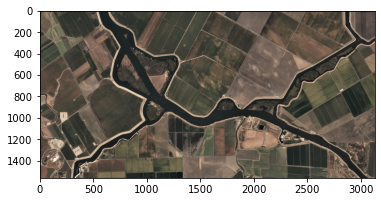

<AxesSubplot:>

In [5]:
from rasterio.mask import mask

# Now we can apply the rasterio mask 
# We specify the function needs to crop (via crop=True)
with rasterio.open(image_file) as img:
    clipped, transform = mask(img, my_geojson, crop=True)

# Let's look at our clipped image
show(clipped)

Finally, we can copy over the metadata from the original image and apply it to our cropped version.

In [6]:
# Let's copy the metadata from the original ratserio object
meta = my_image.meta.copy()

# We will need to update this metadata, and provide the new clipped boundaries
meta.update(
    {
    
        "transform": transform,
        "height":clipped.shape[1],
        "width":clipped.shape[2]
    }
)

# Finally, we can write new image to a GeoTIFF
with rasterio.open('clipped.tif', 'w', **meta) as dst:
    dst.write(clipped)
    
print('Writing complete')

Writing complete
